# Quantitative Finance
**Team**: Davi Barreira, Gabriel Doc, Pedro Dall

Consider the following problem. We wish to liquidate a significant amount of an asset, such that
our actions affect it's price.
If we just try to sell everything at the current market price, our order will walk the book, and thus,
we'll end up selling at a price possibly much lower. To avoid this problem, we wish to break our order
in smaller orders, and "slowly" sell the asset, so that the Limit Order Book can be "replenished".
The problem now is, if you take to long to sell the asset, you are subjected to the market's variation,
and the asset's price might drop (which is probably what you expected, since you wanted to sell!).

Hence, we are looking for an optimal strategy to sell the asset. How fast should we sell it?
Also, we consider that our time-horizon is finite, i.e. we wish to liquidate all the assets
at most at time T (this could be an hour, a day, a month, etc).


## Modeling the Problem
Let's define some of the variables:
* $\nu$ - The strategy to liquidate the asset;
* $\nu_t$ - The rate of which we sell the asset at time $t$.
* $\mu_t$ - The net order flow, i.e. the rate at which the market is buying/selling the asset;
* $X_t^\nu$ - The cash flow of the agent at time $t$ using strategy $\nu$;
* $S_t^\nu$ - The price of the asset at time $t$ under strategy $\nu$;
* $Q_t^\nu$ - Amount of "shares" of the asset the agent is holding at time $t$ with strategy $\nu$;


Our modelling assumptions are the following.
First, we'll assume that the both our action and the market's affect the price of the assets linearly and equally,
and that the price of the asset has a "natural" variability modeled as a Brownian motion with variance $\sigma$. Thus,
the price of the asset is given by

$$
dS^\nu_t = \sigma dW_t + b(\mu_T - \nu_t)dt,
$$

where $b \in \mathbb R_+$, and $W_t$ is the Brownian motion.

The net order flow $\mu_t$ will be modelled as two independent Poisson processes, one for buy orders and another for
sell orders with

$$
d\mu_t = -\kappa \mu_t dt + \eta (dL_t^+ - dL_t^-)
$$

where $\eta$ is the impact of the increase/decrease of order flow, and $\kappa$ is a rate of decay of the jumps.
Our last simplifying assumption is that, when we sell at a rate $\nu_t$, we always walk the book a bit, which
is approximated by a linear equation $k \nu_t$ to model such impact, with $k>0$.

Thus, the cash process of the
agent is given by:

$$
d X_t^\nu = (S^\nu_t - k \nu_t) \nu_t dt.
$$

Note that if we assumed that we always sell the the midprice, then cash process would be simply $dX_t^\nu = S_t^\nu \nu_t dt$, i.e. the amount
of money we get is the amount we trade times the price. The amount of shares we have can be computed as:

$$
dQ_t^\nu = - \nu_t dt.
$$

Lastly, we need to know what function we are going to try to optimize. This is a bit controversial. We might
think that what we want to do is find $\nu \in \mathcal A$ (set of admissible strategies) that maximizes $E[X^\nu_T]$, i.e. maximize the expected value of the agent's
cash at the final time $T$. But, if this was the case, the strategy
is not penalized if it's too slow. Hence, instead of $E[X^\nu_T]$, we'll try to maximize

$$
E\left[X^\nu_T + Q_T^\nu(S^\nu_T - \alpha Q^\nu_T) - \phi \int_t^T (Q^\nu_s)^2 ds\right].
$$

Note that we added two extra terms. The first one was $Q_T^\nu(S^\nu_T - \alpha Q^\nu_T)$. This term penalizes
the strategy if there is still some of the asset left by the end of time $T$. When this happens, the agent
has to sell everthing at market price. But if we do that, the strategy is penalized by the amount of shares times
a parameter $\alpha > 0$.
Secondly,  $\phi \int_t^T (Q^\nu_s)^2 ds$, which penalizes the strategy by how long it holds the asset. This is controlled
by a parameter $\phi>0$. The larget $\phi$, the quicker the agent wants to get rid of the asset.




----
### Ergodicity Economics
Even with some modifications, such optimization function still has a problem... Note that we are trying to
maximize an expected value, but is this what we really want? Mathematicians and economists have noticed a long
time ago that, in practice, humans do not actually "try" to maximize the expected value, but something else.
Economists tried to fix this decoupling between human behavior and what seemed to be the correct mathematical function,
and thus introduced what is called a utility funciton. This function is supposed to model our apparent risk-aversion behavior.
Yet, this is still problematic, because the choice of such utility function seems arbitrary.

Perhaps the best example of such oddity is revealed in the St. Petersburg Paradox. The paradox is the following. Consider a game
in which a fair coin is tossed. If you get "heads", then you add two dollars to your pile. If you flip "heads" again, you double the current amount in your pile,
i.e. the two dollars becomes four, and so on. The game goes on until you flip "tails", in which the game ends and you receive the amount of money currently in the pile.
The question is then, how much money would you pay to play this game? Here is where things get interesting. If you try to
calculate the expected value of this game, you'll find out that it's actually infinite. Hence, if the "fair" price to play the game
is the expected value, then the "rational" thing to do is to play the game for any amount of money...

You can already smell the b.s. in the air. We can intuite that there is something off about this. It's not a surprise that this was
coined as a paradox, since the "logical" answer seems so "unlogical". This problem was posed in 1738 by Daniel Bernoulli, which
proposed to solve it by introducing the "utility function". Yet, this seemed like cheating, since it's not clear how this notion
could "naturally" emerge from the original problem.

It was only in 2011 that the physicist Ole Peters proposed a new solution, which does not make use of any funky utility function,
but instead, relies only in the problem itself. He realized that the St. Petersburg game is not ergodic, i.e.
the time-average of the game is not equal to the ensamble-average (also known as "expected" value).
The only reason the game has infinite expected value is that a tiny fraction of possible games
result in absurds amount of money. But you, a single individual, would only be able to get such
large amount of money if you played the game a zillion times... And if you actually added the amount of money
you had to pay to play each time, you would not make a lot of money. Now we can more clearly see why the expected value of the cash process is not the "correct" thing to maximize.

----

## Analytical Solution

Let's use Dynamic Programming to solve our modelling problem. Remember, we to find the optimal strategy $\nu^* \in \mathcal A$ such that

$$
\nu^* = \arg\sup_{\nu \in \mathcal A} E_{t,x,S,\mu,q}\left[X^\nu_t + Q_T^\nu(S^\nu_T - \alpha Q^\nu_T) - \phi \int_t^T (Q^\nu_s)^2 ds\right] = H^\nu(t,x,S,\mu,q).
$$

Our Stochastic Control Problem is:

$$
\begin{cases}
H(t,x):= \sup_{\nu \in \mathcal A}H^\nu(t,x,S,\mu,q), \\
X^{\nu}_t,\text{ solves } d X_t^\nu = (S^\nu_t - k \nu_t) \nu_t dt, \\
X^{\nu}_T = x,\\
dS^\nu_t = \sigma dW_t + b(\mu_T - \nu_t)dt,\\
d\mu_t = -\kappa \mu_t dt + \eta (dL_t^+ - dL_t^-)
\end{cases}
$$

The typical resolution through Hamilton-Jacobi-Bellman consists in the following steps (from lecture notes):
* Solve the HJB Equation via an educated guess. The HJB equation is the following:
$$
\nabla_t H + 
\sup_{\nu\in \mathcal A}(\mathcal L^\nu H(t,x) + 
$$

## Simulation

In [159]:
using Distributions
using Random
using CairoMakie
CairoMakie.activate!(type = "svg")

In [160]:
Nₛ = 5000 # Number of simulations
T  = 1
Nₜ = Int(360*6.5)
δₜ = T/(360*6.5)
t = range(0,T,step = δₜ)

k, b = 0.001, 0.0001

λ, κ = 1000, 10

# We are simulating η as a r.v comming from an exponential distribution
# with expected value equal to 10
η = Exponential(10)

S₀ = 50   # Initial price of the asset
Q₀ = 1    # Initial amount of "shares"
ϕ  = 0.01 # Penalty for holding the asset
σ  = 0.1  # Volatility for the price process

α  = 100;  # Penalty for having shares at the final time T

$$
\gamma = \sqrt{\frac{\phi}{k}}
$$

$$
\zeta = \frac{\alpha -b/2 + \sqrt{k \phi}}{\alpha -b/2 - \sqrt{k \phi}}
$$

$$
\chi(t) = \sqrt{k \phi} \frac{1+\zeta e^{2\gamma(T-t)}}{1-\zeta e^{2\gamma(T-t)}}
$$

$$
\nu_{t}^{*}=-\frac{1}{k} \chi(t) Q_{t}^{\nu^{*}}-\frac{b}{2 k} \overline{\ell}_{1}(t) \mu_{t}
$$
where $\ell_{1}^{t}$ can be expressed as 
$$
\ell_{1}(t)=b \int_{t}^{T} e^{-\kappa(s-t)} e^{\frac{1}{k} \int_{t}^{s}\chi(u) d u}  d s
$$
and  simplifies to
$$
{\qquad \ell_{1}(t)=b \;\ell(T-t) \geq 0} 
$$
where
$$
 {\qquad \ell(\tau)=\frac{1}{\zeta e^{\gamma \tau}-e^{-\gamma \tau}}\left\{e^{\gamma \tau} \frac{1-e^{-(\kappa+\gamma) \tau}}{\kappa+\gamma} \zeta-e^{-\gamma \tau} \frac{1-e^{-(\kappa-\gamma) \tau}}{\kappa-\gamma}\right\}}
$$

#### Computing the constants

In [161]:
γ = √(ϕ/k)
ζ = (α - b/2 + √(k*ϕ))/(α - b/2 - √(k*ϕ))
τ = T .- t
χ = @. √(k*ϕ)*(1 + ζ*exp(2*γ * τ))/(1 - ζ*exp(2*γ * τ))
ℓ = @. (1/(ζ*exp(γ*τ) - exp(-γ * τ))) * (exp(γ*τ) * ((1 - exp(-(κ + γ)*τ))/(κ + γ))*ζ -  exp(-γ*τ) * ((1 - exp(-(κ - γ)*τ))/(κ - γ)));

#### Initializing Variables

In [162]:
μ = zeros(Nₛ, Nₜ+1)
ν = zeros(Nₛ, Nₜ+1)

X = zeros(Nₛ, Nₜ+1)

Q = zeros(Nₛ, Nₜ+1)
Q[:,1] .= Q₀

S = zeros(Nₛ, Nₜ+1)
S[:,1] .= S₀;

In [163]:
Random.seed!(7)
for i in 1:Nₜ
    ν[:,i] .= -1/k * χ[i]*Q[:, i] - 0.5 * b/k * ℓ[i] * μ[:,i]
    
    X[:, i+1] .= X[:, i] + (S[:, i] - k * ν[:,i]) .* ν[:,i] * δₜ
    Q[:, i+1] .= Q[:, i] - ν[:, i] * δₜ
    
    dW = (√δₜ) * randn(Nₛ)
    
    S[:, i+1] .= S[:, i] + b* (μ[:, i] - ν[:, i]) * δₜ + (σ * dW)
    
    # Note that since we have two independent Poisson processes with λ
    # this is the same as a process with parameter 2λ
    dη = rand(Nₛ) .<  (1 - exp(-2 * λ * δₜ))
    
    # Sample η ∼ Exponential and multiplies by +1 or -1 with 0.5 probability each
    ηₛ = rand(η, Nₛ).*rand([-1,+1],Nₛ)
    
    # Calculate μₜ₊₁
    μ[:, i+1] .= μ[:, i] * exp(-κ * δₜ) + ηₛ .* dη
    
end

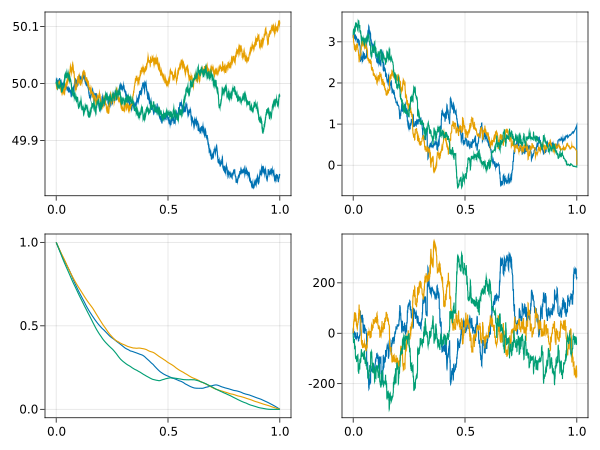

In [175]:
f = Figure()

ax1 = Axis(f[1,1])
lines!(ax1, t, S[1,:])
lines!(ax1, t, S[2,:])
lines!(ax1, t, S[3,:])

ax2 = Axis(f[2,1])
lines!(ax2, t, Q[1,:])
lines!(ax2, t, Q[2,:])
lines!(ax2, t, Q[3,:])

ax3 = Axis(f[1,2])
lines!(ax3, t, ν[1,:])
lines!(ax3, t, ν[2,:])
lines!(ax3, t, ν[3,:])

ax4 = Axis(f[2,2])
lines!(ax4, t, μ[1,:])
lines!(ax4, t, μ[2,:])
lines!(ax4, t, μ[3,:])
f